# Absolute player positions dataframe in a match

In [ ]:
!pip install pymongo

In [101]:
import pymongo
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# standard libraries
import pickle
# custom libraries
import utils
import stats
# to silent warnings
import warnings
warnings.filterwarnings("ignore")

### Database Access

In [102]:
# database credentials
dbname = 'lol2'
user = 'lol2i'
passw = 'GoogleTest19'
ip = "5.196.92.209"
port = 35420
# connecting to the client
client = pymongo.MongoClient(ip,port,username=user,password=passw,authSource=dbname)

db = client[dbname]

In [103]:
# extract 100 random gameids
gameids = db.games.find()
storedids = []
import random
maxids = 100
i = 0
for g in gameids:
    if(i<maxids and bool(random.getrandbits(1))):
        storedids.append(g['gameId'])
        i += 1
    elif(i>=maxids):
        break

In [104]:
# save global statistics about all 100 games, we want to find correlation between the win/lose and the other events.
globaldfstats = []

for gameid in storedids:
    game = db.games.find({'gameId': gameid})[0]
    statsparticipant = []
    for p in game['participants']:

        statsparticipant.append(p['stats'])


    dfstats = pd.DataFrame(statsparticipant)
    globaldfstats.append(dfstats)

### Statistics by match results

In [105]:
# let's group the data by winners and losers and compute the means of every event
globaldf = pd.concat(globaldfstats).reset_index(drop=True)
groupedglobaldf = globaldf.groupby(['win']).mean().T

In [106]:
# here the standard deviation
groupedglobalstd = globaldf.groupby(['win']).std().T
df_tot = np.hstack([groupedglobaldf,groupedglobalstd])

In [107]:
# dropping zero values to avoid nan values in t test
groupedglobaldf_nozero = groupedglobaldf[(groupedglobaldf.T != 0).any()]

In [108]:
groupedglobaldf_nozero.head(10)

win,False,True
assists,8.131687,12.080247
champLevel,13.744856,14.872428
damageDealtToObjectives,3617.915638,9501.010288
damageDealtToTurrets,1202.372428,3754.604938
damageSelfMitigated,15854.962963,15569.032922
deaths,7.672840,5.193416
doubleKills,0.491770,0.897119
firstBloodKill,0.076132,0.129630
firstTowerAssist,0.053498,0.139918
firstTowerKill,0.032922,0.125514


In [110]:
# let's stack the two data frames (mean and standard deviation)
names = ['mean_lose','mean_win','std_lose','std_win']
x = pd.DataFrame(df_tot, columns=names)
x.head()

,mean_lose,mean_win,std_lose,std_win
0,8.131687,12.080247,6.486715,7.298054
1,13.744856,14.872428,2.440366,2.091756
2,0.000000,0.000000,0.000000,0.000000
3,3617.915638,9501.010288,5406.505525,9557.680940
4,1202.372428,3754.604938,1669.988835,3004.301559


### Computing the T test

In [111]:
# since we've already computed means and standard deviations 
# we need to define a function for computing the t test using scalars
def Ttest(x):
    """
    Compute T Test using scalar values
    
    Parameters
    ----------
    x : pd.DataFrame
        Dataframe filtered by colums
    
    Returns
    -------
    pd.Series[float]
        T Test results
    """
    t = (x['mean_lose']-x['mean_win'])/(np.sqrt((x['std_lose']**2/100)+(x['std_win']**2/100)))
    return t

In [112]:
# assigning t test column to dataframe
x['ttest'] = Ttest(x)

In [113]:
# drop missing values
x = x.dropna()

In [114]:
# checking if the differences in means are statistically significative
x['sign005'] = x['ttest'].apply(lambda x: 'nodiff' if np.abs(x)<1.96 else 'diff')

In [115]:
# let's add the events associated to the tests
x['events'] = groupedglobaldf_nozero.index

In [116]:
# now let's take only the significative ones.
sign_vars = x[x['sign005'] == 'diff']
sign_vars.sort_values(by="ttest",ascending=False,inplace=True)

### Plot the results

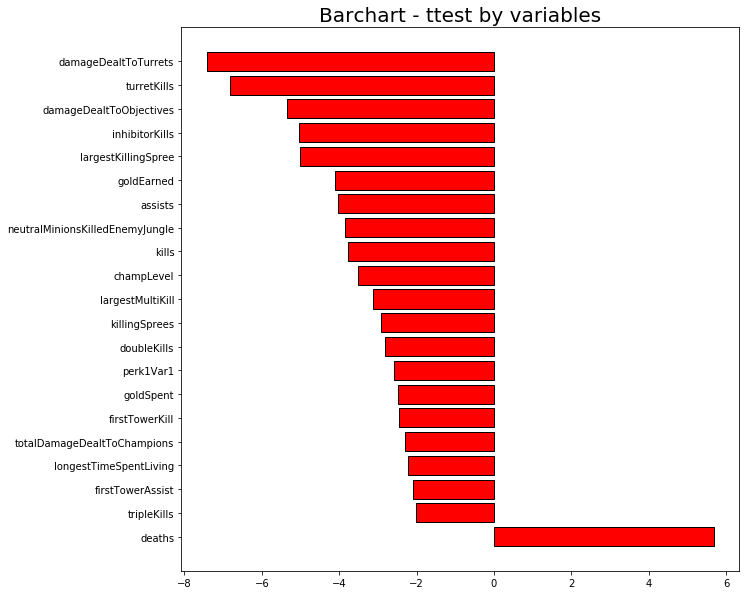

In [117]:
# now we can plot the differences in means (only for significative differences)
plt.figure(figsize=(10,10))
plt.barh(sign_vars["events"],sign_vars["ttest"],color='red',edgecolor='black')
plt.title('Barchart - ttest by variables',fontsize=20)
stats.saveImage('ttest_barchart')
plt.show()